In [95]:
import os
import tarfile
import urllib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

### Load Data ###

In [36]:
# Create the data download path
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/refs/heads/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_URL

'https://github.com/ageron/handson-ml2/raw/refs/heads/master/datasets/housing/housing.tgz'

In [37]:
# Fetch housing data from source
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [38]:
fetch_housing_data()

C:\Users\Milad\AppData\Local\Temp\ipykernel_26712\3464714791.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [39]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [40]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [41]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [42]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [43]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

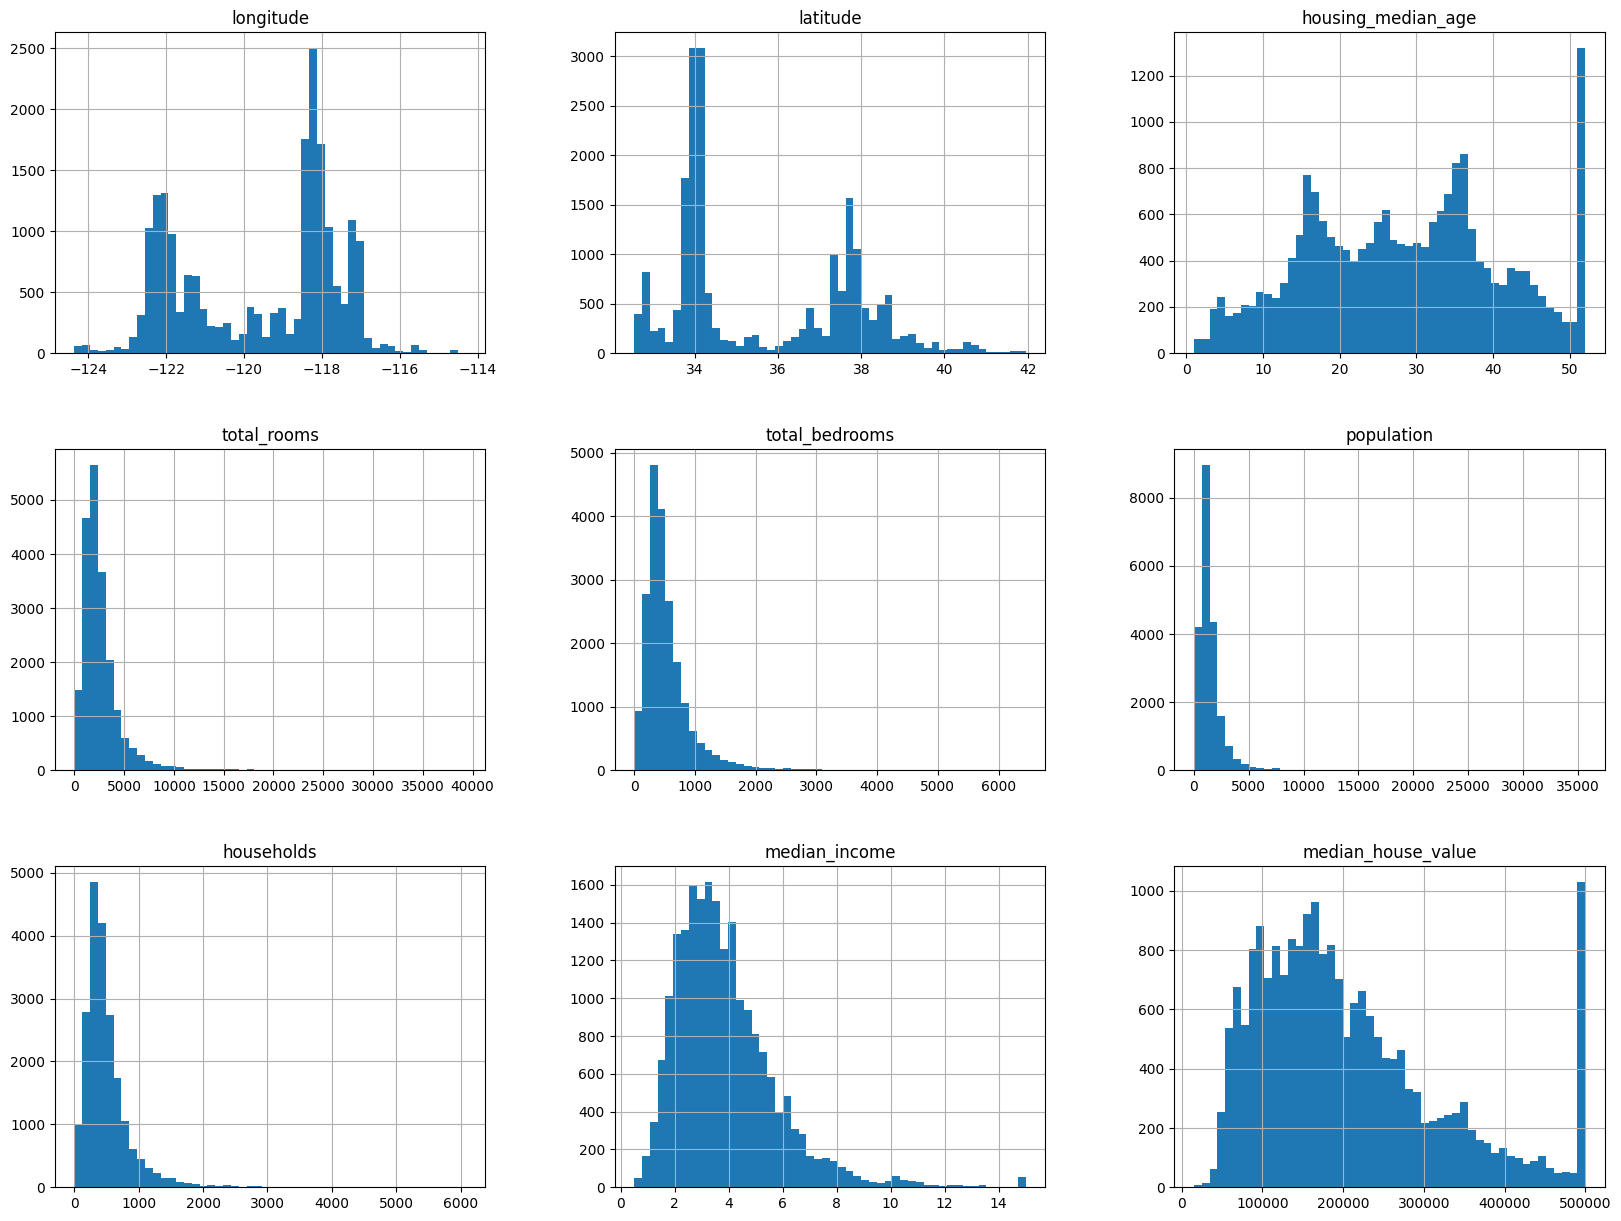

In [44]:
housing.hist(bins=50, figsize=(20,15))

### Creating Stratified Train and Test sets

<Axes: >

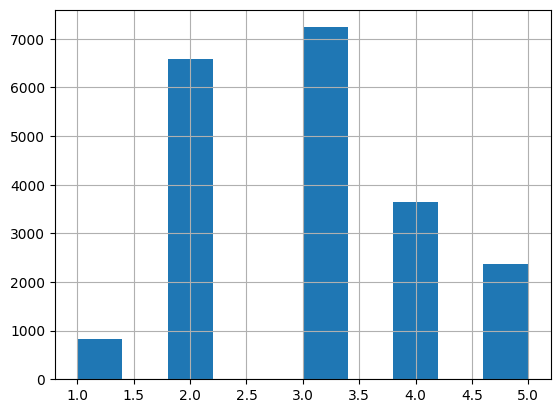

In [45]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6., np.inf], labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [46]:
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [47]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [48]:
# Drop the `income_cat` to get back to original dataset attributes
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat',axis=1, inplace=True)

### Exploring Data ###

In [49]:
# Create a copy to avoid harming original data
## Also we set aside the test set (Avoid data snooping bias!)

housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

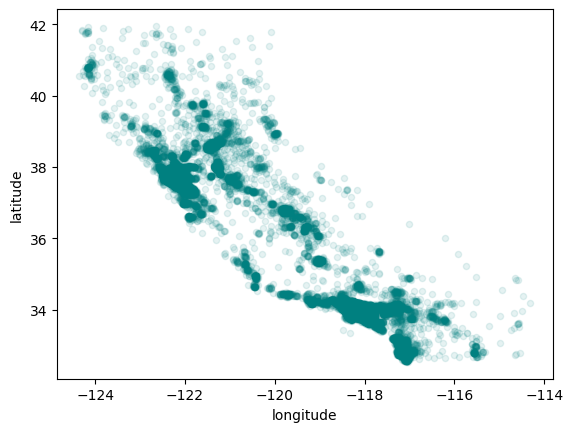

In [50]:
housing.plot(kind='scatter', x='longitude', y='latitude', color='teal', alpha=.1)

<Axes: xlabel='longitude', ylabel='latitude'>

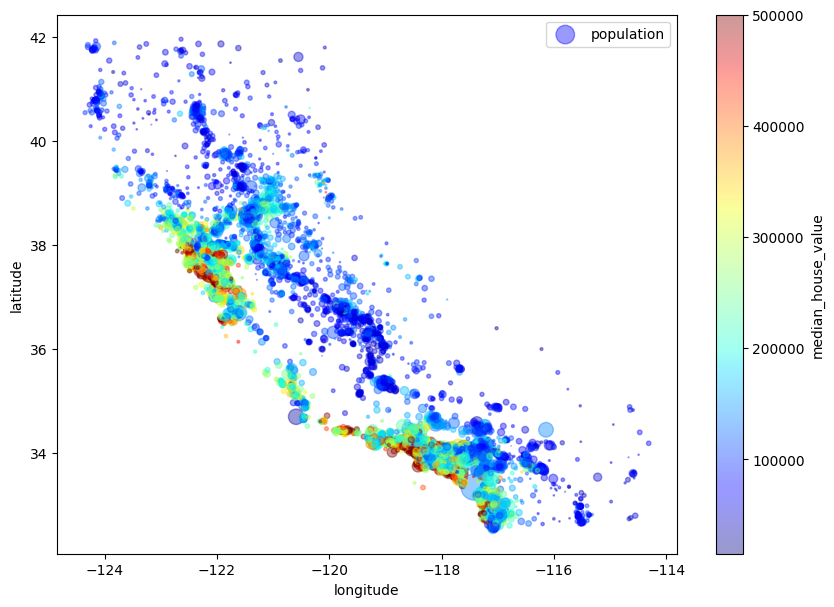

In [51]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population'] / 100, label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

In [52]:
# Checking correlation between attributes
corr_matrix = housing.corr(method='pearson' ,numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [53]:
attributes = ['median_house_value','median_income', 'total_rooms', 'housing_median_age']

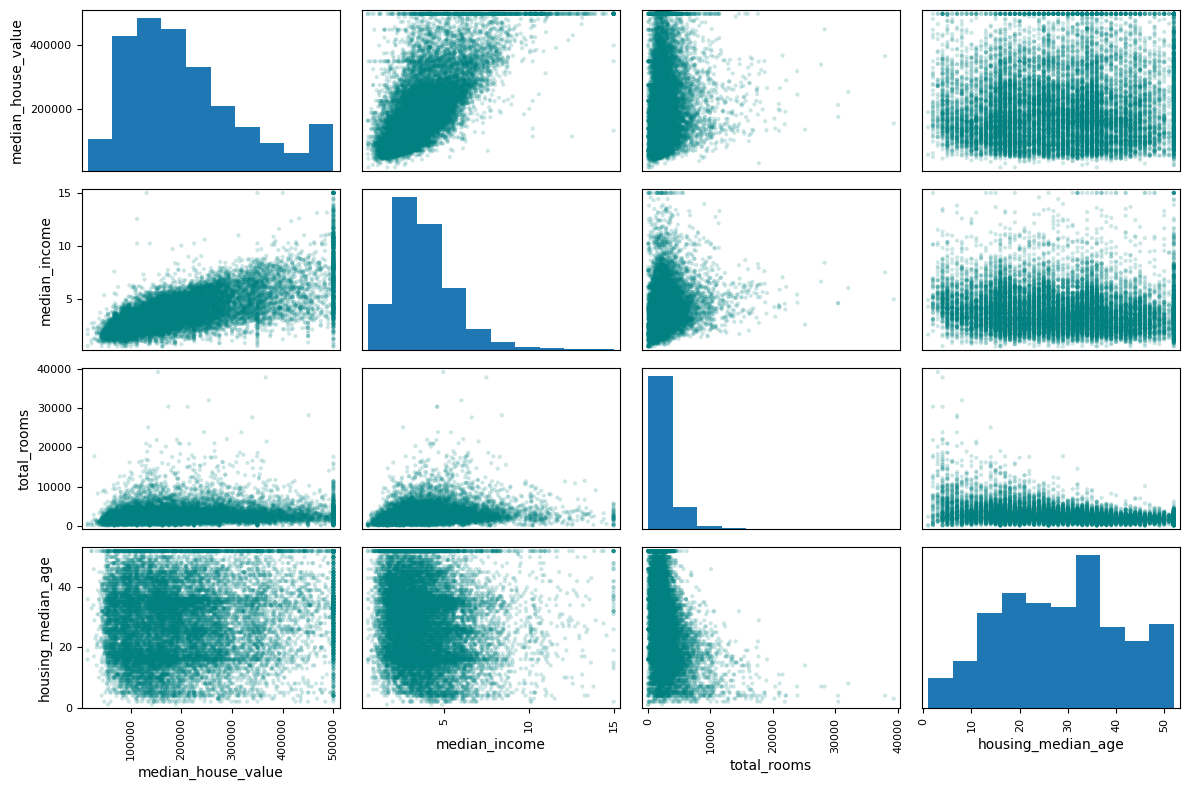

In [54]:
from pandas.plotting import scatter_matrix

scatter_matrix(housing[attributes], figsize=(12,8), alpha=.2, c='teal')
plt.tight_layout()
plt.show()

In [21]:
# Extract new features
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

# Checking correlation between attributes
corr_matrix = housing.corr(method='pearson' ,numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Data Preparation for ML model ###

In [55]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [56]:
# Take care of missing values
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [57]:
# Fill the missing data using median of the corresponding attribute
X= imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [58]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [59]:
# Convert categorical to numerical attributes
# Using OrdinalEncoder is not suitable here since the categories does not have any (proximity) relationship
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [60]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [70]:
for i,c in enumerate(housing.columns):
    print(f'{c} - {i}')

longitude - 0
latitude - 1
housing_median_age - 2
total_rooms - 3
total_bedrooms - 4
population - 5
households - 6
median_income - 7
ocean_proximity - 8


In [91]:
# Custom
rooms_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



### Data Cleaning Pipeline ###


In [92]:
print(f'X : {X.shape}')
print(f'housing : {housing.shape}')
print(f'housing_num : {housing_num.shape}')



X : (16512, 8)
housing : (16512, 9)
housing_num : (16512, 8)


In [94]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
     ('attribs_adder',CombinedAttributesAdder()),
     ('std_scaler', StandardScaler())
])

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [98]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)

### Train ###

In [105]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression()

### Evaluation ###

In [107]:
from sklearn.metrics import mean_squared_error

#### Linear Regression ####

In [106]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predictions:", lin_reg.predict(some_data_prepared))
print("labels:", list(some_labels))

predictions: [ 85120. 305856. 152256. 186624. 244480.]
labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [108]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68634.44789635955

#### DecisionTree Regression ####

In [109]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [110]:
housing_predictions = dt_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [111]:
# using cross-validation

In [112]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse = np.sqrt(-scores)

In [114]:
def display_scores(scores):
    print(scores)
    print(f'Mean: {scores.mean()}')
    print(f'Std: {scores.std()}')

display_scores(tree_rmse)


[73405.45704435 70830.06705539 69560.29523958 71762.56384435
 69153.55596614 77629.6990915  71638.9649629  72787.44293475
 68203.14099151 70800.53984136]
Mean: 71577.1726971833
Std: 2529.145502715004


In [115]:
lin_rmse_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_rmse_scores)
display_scores(lin_rmse_scores)


[71778.64956897 64114.99166359 67771.17124356 68613.18677014
 66828.8611363  72551.43826898 73997.08050233 68830.50397661
 66443.28836884 70144.65874699]
Mean: 69107.38302462916
Std: 2886.202548783683


In [116]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_reg_predictions = forest_reg.predict(housing_prepared)

forest_reg_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error' , cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)
display_scores(forest_reg_rmse_scores)


[51546.96987173 49242.92407027 46800.74799133 52368.92179538
 47641.14048958 52035.32157694 52513.58636233 49807.00784769
 48344.27381191 53949.05674306]
Mean: 50424.995056020896
Std: 2267.2818199684375


### Fine-Tune ###

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30],
     'max_features': [2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2,3,4]  }
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator=forest_reg,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [118]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [119]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [120]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64537.74496800154 {'max_features': 2, 'n_estimators': 3}
55205.77351920809 {'max_features': 2, 'n_estimators': 10}
52407.59162432327 {'max_features': 2, 'n_estimators': 30}
59747.55099161522 {'max_features': 4, 'n_estimators': 3}
53133.32531273985 {'max_features': 4, 'n_estimators': 10}
50341.144600108346 {'max_features': 4, 'n_estimators': 30}
58616.55967859703 {'max_features': 6, 'n_estimators': 3}
52690.38050507094 {'max_features': 6, 'n_estimators': 10}
50206.91328014194 {'max_features': 6, 'n_estimators': 30}
58062.80974381199 {'max_features': 8, 'n_estimators': 3}
51923.88595986889 {'max_features': 8, 'n_estimators': 10}
49999.11930286905 {'max_features': 8, 'n_estimators': 30}
62611.458066464475 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53972.53479060677 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60100.58926543584 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52480.67784049802 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [121]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances 

array([7.53533743e-02, 6.78880902e-02, 4.12256661e-02, 1.51288987e-02,
       1.42927928e-02, 1.42509181e-02, 1.38265125e-02, 3.55651674e-01,
       3.77068521e-02, 1.11527882e-01, 8.88593470e-02, 9.97247026e-03,
       1.45988439e-01, 6.75803520e-05, 3.12442805e-03, 5.13507470e-03])

In [125]:
cat_encoder

OneHotEncoder()

In [126]:
extra_attribs = ['rooms_per_hhold', "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3556516736733571, 'median_income'),
 (0.14598843884333002, 'INLAND'),
 (0.1115278824391017, 'pop_per_hhold'),
 (0.08885934697295528, 'bedrooms_per_room'),
 (0.07535337434849024, 'longitude'),
 (0.06788809018325993, 'latitude'),
 (0.04122566605282857, 'housing_median_age'),
 (0.03770685211903051, 'rooms_per_hhold'),
 (0.01512889865004205, 'total_rooms'),
 (0.014292792813162411, 'total_bedrooms'),
 (0.01425091810006536, 'population'),
 (0.013826512451190619, 'households'),
 (0.009972470255644943, '<1H OCEAN'),
 (0.005135074699860464, 'NEAR OCEAN'),
 (0.0031244280457266597, 'NEAR BAY'),
 (6.75803519542603e-05, 'ISLAND')]

### Final Model ###

In [129]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47962.71334505897

In [132]:
from scipy import stats

confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors)- 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))


array([45935.58789463, 49907.56964244])